In [1]:
import numpy as np
import cv2
import skimage.io as skio
import json
import scipy.interpolate as ssi
import matplotlib.pyplot as plt
import imageio
import skimage as ski

import skimage.transform
import scipy.signal as ssg
from scipy.spatial.distance import cdist, pdist

In [2]:
def stack_ones(pts):
    return np.concatenate([pts, np.ones((pts.shape[0], 1))], axis=1)

def stack_zeros(pts):
    return np.concatenate([pts, np.zeros((pts.shape[0], 1))], axis=1)

In [3]:
def warpImage(im, H, h_min, w_min, h_max, w_max):
    new_h = h_max - h_min
    new_w = w_max - w_min

    y_dest, x_dest = np.indices([new_h, new_w])
    dest = np.vstack([x_dest.ravel() + w_min, y_dest.ravel() + h_min, np.ones(x_dest.size)])
    backward_pts_homog = (np.linalg.inv(H) @ dest) # backward points in homogenous coordinates
    backward_pts = (backward_pts_homog[:2]/backward_pts_homog[2]).T # Convert
    
    backward_pts = np.flip(backward_pts, axis=1)
    interp = ssi.RegularGridInterpolator((np.arange(im.shape[0]), np.arange(im.shape[1])), im, bounds_error=False, fill_value=0) # An interpolator
    
    warped_pts = interp(backward_pts)
    warped_im = np.zeros([new_h, new_w, im.shape[-1]])
    warped_im[y_dest.ravel(), x_dest.ravel()] = warped_pts
    return warped_im

In [4]:
def computeH(x, y):
    b = y.flatten()
    
    A = []
    for row in range(len(x)*2):
        A.append([0]*8)

        offset = 0
        if row % 2 == 1:
            offset = 3
        A[-1][offset] = x[row // 2][0]
        A[-1][offset + 1] = x[row // 2][1]
        A[-1][offset + 2] = 1

        A[-1][-2] = -x[row//2][0]*b[row]
        A[-1][-1] = -x[row//2][1]*b[row]

    A = np.array(A)
    H = np.concatenate([np.linalg.lstsq(A, b)[0], [1]]).reshape(3, 3)
    return H

In [5]:
def getWarpedImBounds(im, H):
    h, w = im.shape[:2]
    corners = np.array([[0, 0, 1], [w - 1, 0, 1], [0, h - 1, 1], [w - 1, h - 1, 1]])

    warped_corners_homog = H @ corners.T
    warped_corners = warped_corners_homog[:2]/warped_corners_homog[2:]

    w_min, h_min = np.floor(np.min(warped_corners, axis=1)).astype(int)
    w_max, h_max = np.ceil(np.max(warped_corners, axis=1)).astype(int)
    return h_min, w_min, h_max, w_max

In [6]:
def visualize_points(pts, im):
    plt.plot(pts[:, 0], pts[:, 1], 'o')
    plt.gca().set_aspect("equal")
    plt.imshow(im)
#     plt.axis("off")
    plt.show()

In [7]:
import numpy as np
from skimage.feature import corner_harris, peak_local_max


def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=1)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords


def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """
    
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert dimx == dimc, 'Data dimension does not match dimension of centers'

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)


In [8]:
def get_patches(bw_im, h, coords):
    patches = []
    for c in coords:
        patch = bw_im[c[1] - 20: c[1] + 20, c[0] - 20: c[0] + 20]
        patch = ski.transform.rescale(patch, 1/5, channel_axis=2)
        patch = (patch - patch.mean(axis=1))/patch.std(axis=1)
        patches.append(patch.flatten())
    patches = np.array(patches)
    
    return patches

In [9]:
def ransac_old(X, y, iterations=100000, n = 4, inlier_threshold=6, error_threshold=1):
    best_error = float('inf')
    best_H = None
    n = min(n, X.shape[0])
    for _ in range(iterations):
        ridx = np.random.choice(np.array(X.shape[0]), size=n, replace=False) # inliers points
        xs = X[ridx]
        ys = Y[ridx]

        H = computeH(xs, ys)
        pred = H @ stack_ones(X).T
        pred = (pred[:2]/pred[2]).T
        
        # Get the inliers
        errors = np.sum((Y - pred)**2, axis=1) #np.linalg.norm(Y - pred)
        inliers = np.argwhere(errors < error_threshold)
        
        if np.prod(inliers.shape) >= inlier_threshold:
            X_inlier = X[inliers[:, 0]]
            Y_inlier = Y[inliers[:, 0]]
            better_H = computeH(X_inlier, Y_inlier)
            
            better_inlier_pred = better_H @ stack_ones(X_inlier).T
            better_inlier_pred = (better_inlier_pred[:2]/better_inlier_pred[2]).T
            
            inlier_error = np.sum((Y_inlier - better_inlier_pred)**2, axis=1).mean()
            
            if inlier_error < best_error:
                best_error = inlier_error
                best_H = better_H
    if best_H is None:
        assert False == True, "Failed to find a solution"
    return best_H

In [10]:
def ransac(X, y, iterations=1000, n = 4, error_threshold=5):
    most_inliers = 0
    largest_X_inlier = None
    largest_Y_inlier = None
    n = min(n, X.shape[0])
    for _ in range(iterations):
        ridx = np.random.choice(np.array(X.shape[0]), size=n, replace=False) # inliers points
        xs = X[ridx]
        ys = Y[ridx]

        H = computeH(xs, ys)
        pred = H @ stack_ones(X).T
        pred = (pred[:2]/pred[2]).T
        
        # Get the inliers
        errors = np.sum((Y - pred)**2, axis=1) #np.linalg.norm(Y - pred)
        inliers = np.argwhere(errors < error_threshold)
        
        X_inlier = X[inliers[:, 0]]
        Y_inlier = Y[inliers[:, 0]]
        
        if X_inlier.shape[0] > most_inliers:
            most_inliers = X_inlier.shape[0]
            largest_X_inlier = X_inlier
            largest_Y_inlier = Y_inlier
        
    if most_inliers < 4:
        print("Failed to find a solution")
        return np.eye(3)
    best_H = computeH(largest_X_inlier, largest_Y_inlier)
        
    return best_H

In [11]:
def anms(h, coords, nip=500, crobust=0.9):
    """
    Implements Adaptive non-maximal suppresion
    """
    dists = cdist(coords, coords)
    closest = np.argsort(dists, axis=1)
    first_larger = np.argmax((h[closest] <= np.tile(h[:, np.newaxis], h.shape[0])*crobust)[:, 1:], axis=1) + 1
    first_larger = closest[np.arange(closest.shape[0]), first_larger]
    ris = dists[np.arange(dists.shape[0]), first_larger]
    
    indices = np.argsort(ris)
    return indices[-nip:]

In [12]:
def blendingGradient(shape):
    """
    Gets an opacity gradient for an image of shape shape that we can use for blending
    """
    topgrad = np.tile(np.linspace(0, 1, shape[0]//2)[:, np.newaxis], shape[1])
    bottomgrad = np.tile(np.linspace(1, 0, shape[0]//2)[:, np.newaxis], shape[1])
    leftgrad = np.tile(np.linspace(0, 1, shape[1]//2)[:, np.newaxis], shape[0])
    rightgrad = np.tile(np.linspace(1, 0, shape[1]//2)[:, np.newaxis], shape[0])

    vertgrad = np.concatenate([topgrad, bottomgrad])
    horzgrad = np.concatenate([leftgrad, rightgrad]).T
    grad = horzgrad*vertgrad

    return grad

In [104]:
format_type = "berkeley"
left = skio.imread(f"imgs/{format_type}_left.jpg")
center = skio.imread(f"imgs/{format_type}_center.jpg")
right = skio.imread(f"imgs/{format_type}_right.jpg")

In [105]:
# original_ims = [left, center, right]
# original_ims = [ski.transform.rescale(im, 1/2, channel_axis=2) for im in original_ims]

ims = [left, center, right]
scale = 1/8 # 1/16
ims = [ski.transform.rescale(im, scale, channel_axis=2) for im in ims]

In [106]:
bw_ims = [im.sum(axis=-1)[..., np.newaxis] for im in ims]
hs_and_corners = [get_harris_corners(im) for im in bw_ims]

In [107]:
hs = [pair[0] for pair in hs_and_corners]
full_coords = [pair[1].T for pair in hs_and_corners]

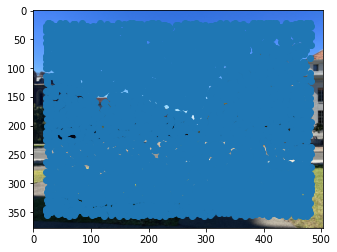

In [108]:
visualize_points(np.flip(full_coords[1], axis=1), ims[1])

In [109]:
# Adaptive Non-Maximal Suppression
nip = 500
ris = [anms(hs[i][full_coords[i][:, 0], full_coords[i][:, 1]], full_coords[i], nip=nip) for i in range(len(ims))]

In [110]:
coords = [np.flip(full_coords[i][ris[i]], axis=1) for i in range(len(ims))]

In [111]:
patches = [get_patches(bw_ims[i], hs[i], coords[i]) for i in range(len(ims))]

In [120]:
coords[1][0]

array([413, 293], dtype=int64)

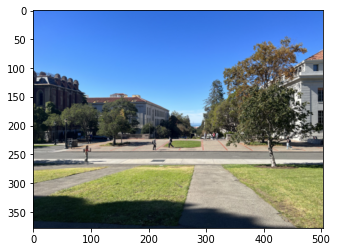

In [121]:
plt.imshow(ims[1])

In [153]:
im = ims[1]
patch = coords[1][119]
dup_im = im.copy()


In [149]:
matches[0][]

array([[ 24,  64],
       [113, 119],
       [133,  14],
       [149, 309],
       [203, 254],
       [206, 205],
       [214, 371],
       [218, 185],
       [238, 393],
       [273, 388],
       [306, 315],
       [308, 382],
       [317, 371],
       [345, 283],
       [440, 371],
       [480, 283]], dtype=int64)

In [154]:
dup_im[patch[1] - 20: patch[1] + 20, patch[0] - 21 : patch[0] - 19] = 255
dup_im[patch[1] - 20: patch[1] + 20, patch[0] + 19 : patch[0] + 21] = 255
dup_im[patch[1] - 21: patch[1] -19, patch[0] - 20 : patch[0] + 20] = 255
dup_im[patch[1] + 19: patch[1] + 21, patch[0] - 20 : patch[0] + 20] = 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


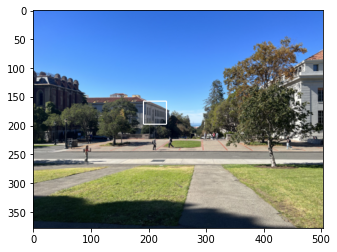

In [155]:
plt.imshow(dup_im)

In [190]:
_patch = im[patch[1] - 20: patch[1] + 20, patch[0] - 20: patch[0] + 20]

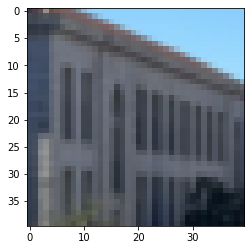

In [191]:
plt.imshow(_patch)

In [204]:
def showgray(im):
    if len(im.shape) == 3:
        plt.imshow(np.tile(im, 3))
    else:
        plt.imshow(np.tile(im[..., np.newaxis], 3))

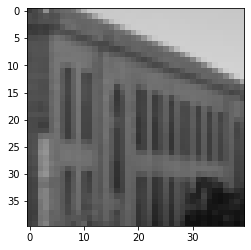

In [200]:
_patch = _patch.mean(axis=-1)
showgray(_patch)

In [201]:
_rescaled_patch = ski.transform.rescale(_patch[..., np.newaxis], 1/5, channel_axis=2)

In [203]:
_rescaled_patch.shape

(8, 8, 1)

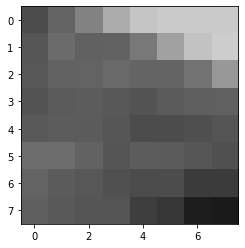

In [205]:
showgray(_rescaled_patch)

In [206]:
_rescaled_patch = (_rescaled_patch - _rescaled_patch.mean())/_rescaled_patch.std()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


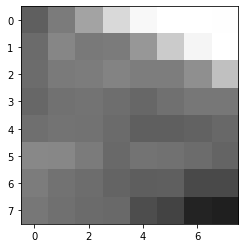

In [216]:
showgray((_rescaled_patch*50 + 255/2).astype(int))

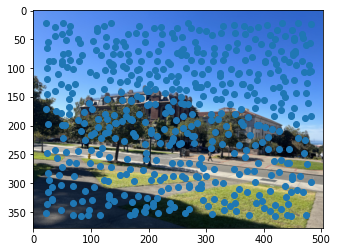

In [112]:
visualize_points(coords[0], ims[0])

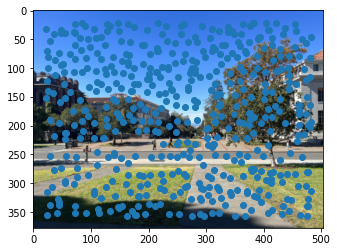

In [113]:
visualize_points(coords[1], ims[1])

In [114]:
# Get the pairwise distances between each images' patches
fdists = []
for i in range(len(ims) - 1):
    for j in range(i + 1, len(ims)):
        fdists.append(cdist(patches[i], patches[j]))

In [115]:
# Get the matching points between each combination of images
outlier_threshold = 0.6
matches = [] # Each element is an array of pairs. The first # in the pair is the index of the corner in the first image, the second, in the second
for fdist in fdists:
    asort = np.argsort(fdist, axis=1)
    fdists_sorted = fdist[np.tile(np.arange(nip)[:, np.newaxis], nip), asort]
    outlier_score = fdists_sorted[:, 0]/fdists_sorted[:, 1]
    best_matches = np.argwhere(outlier_score < outlier_threshold)
    matches.append(np.stack([best_matches[:, 0], asort[best_matches][:, 0, 0]], axis=0).T)

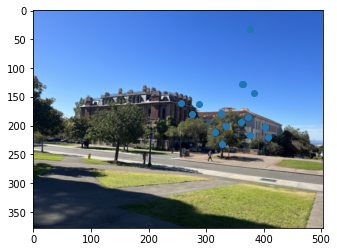

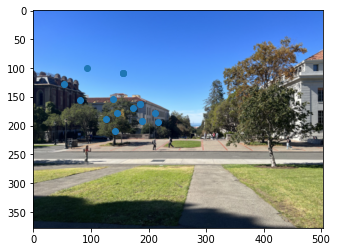

In [116]:
# Visualize matches for a sanity check!
visualize_points(coords[0][matches[0][:, 0]], ims[0])
visualize_points(coords[1][matches[0][:, 1]], ims[1])

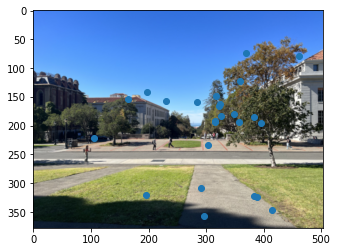

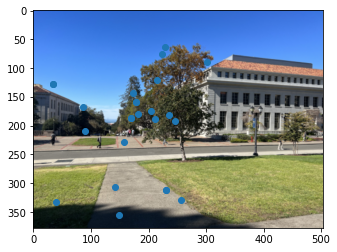

In [117]:
# Visualize matches for a sanity check!
visualize_points(coords[1][matches[2][:, 0]], ims[1])
visualize_points(coords[2][matches[2][:, 1]], ims[2])

In [93]:
# The first two dimensions of Hs are indexing, the last two are the homography matrix
Hs = []
n = len(ims)
match_index = 0
for i in range(n - 1):
    Hs.append([None]*n)
    for j in range(i + 1, n):
        X = coords[i][matches[match_index][:, 0]] #np.flip(coords[i][matches[match_index][:, 0]], axis=1)
        Y = coords[j][matches[match_index][:, 1]] #np.flip(coords[j][matches[match_index][:, 1]], axis=1)
        
        print(f"Computing RANSAC from image {i} to {j}")
        Hs[i][j] = ransac(X, Y)
        match_index += 1
Hs.append([None]*n)

# Add the inverse of the homographies on the lower triangle
for i in range(1, n):
    for j in range(0, i):
        Hs[i][j] = np.linalg.inv(Hs[j][i])

# For completeness, add the identity matrix along the diagonal
for i in range(0, n):
    Hs[i][i] = np.eye(3)
Hs = np.array(Hs)

Computing RANSAC from image 0 to 1
Computing RANSAC from image 0 to 2
Computing RANSAC from image 1 to 2


<ipython-input-4-5afc2942f5f0>:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H = np.concatenate([np.linalg.lstsq(A, b)[0], [1]]).reshape(3, 3)


In [94]:
testwarp = warpImage(ims[0], Hs[0][1], 0, 0, ims[1].shape[0], ims[1].shape[1])

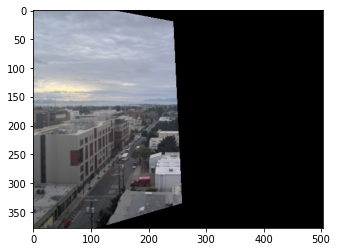

In [95]:
plt.imshow(testwarp)

In [96]:
testwarp = warpImage(ims[2], Hs[2][1], -250, -60, ims[1].shape[0] + 20,  200 + ims[1].shape[1])

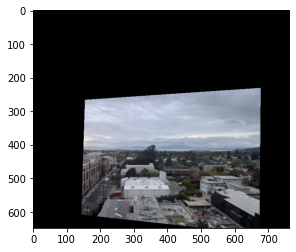

In [97]:
plt.imshow(testwarp)

In [98]:
# Make the images have an opacity layer for blending
blending_ims = [np.concatenate([im, blendingGradient(im.shape)[..., np.newaxis]], axis=-1) for im in ims]

In [99]:
warps = [[0, 1], [2, 1]] # Pairs of [warp from, warp to]
dst_i = 1 # Index of destination image
dst = blending_ims[dst_i]

bounds = [0, 0, dst.shape[0], dst.shape[1]]
for warp in warps:
    # h_min, w_min, h_max, w_max = getWarpedImBounds(ims[warp[0]], Hs[warp[0], warp[1]])
    h_min, w_min, h_max, w_max = getWarpedImBounds(blending_ims[warp[0]], Hs[warp[0], warp[1]])
    bounds[0] = min(bounds[0], h_min)
    bounds[1] = min(bounds[1], w_min)
    bounds[2] = max(bounds[2], h_max)
    bounds[3] = max(bounds[3], w_max)
    
warped = []
for warp in warps:
    warped.append(warpImage(blending_ims[warp[0]], Hs[warp[0], warp[1]], bounds[0], bounds[1], bounds[2], bounds[3]))

In [100]:
padded_dst = np.pad(dst, np.abs([[bounds[0], bounds[2] - dst.shape[0]], [bounds[1], bounds[3] - dst.shape[1]], [0, 0]]))
images_to_blend = warped + [padded_dst]

In [101]:
blended = sum([im[..., :3]*im[..., 3:] for im in images_to_blend])
opacity = sum([im[..., 3:] for im in images_to_blend])
opacity[opacity == 0] = 1
blended = blended/opacity

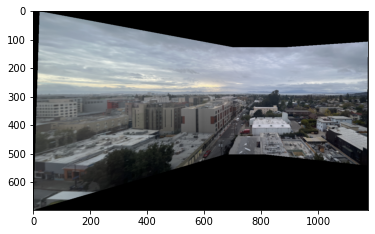

In [102]:
plt.imshow(blended)

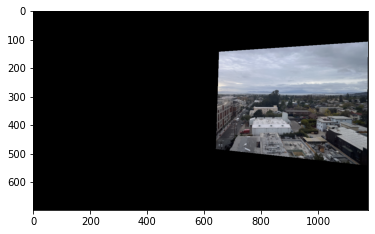

In [219]:
plt.imshow(warped[1][..., :3])

In [103]:
ski.io.imsave(f"outs/part2/{format_type}_panorama.jpg", (blended*255).astype(np.uint8))

In [ ]:
blended = leftwarped[..., :3] * leftwarped[..., 3:] + rightwarped[..., :3] * rightwarped[..., 3:] + dst[..., :3] * dst[..., 3:]
opacity = leftwarped[..., 3:] + rightwarped[..., 3:] + dst[..., 3:]
opacity[opacity == 0] = 1
blended = blended/opacity

In [46]:
blended = np.zeros((bounds[2] - bounds[0], bounds[3] - bounds[1], 3))
n = len(warps)
for i in range(n):
    blended += warped[i]/(n + 1)
    
# Shape the destination image to be in the right location
padded_dst = np.pad(dst, np.abs([[bounds[0], bounds[2] - dst.shape[0]], [bounds[1], bounds[3] - dst.shape[1]], [0, 0]]))
blended += padded_dst/(n+1)

ValueError: operands could not be broadcast together with shapes (791,1516,3) (791,1516,4) (791,1516,3) 

In [33]:
bounds

[-169, -692, 622, 824]

In [34]:
dst.shape

(378, 504, 3)

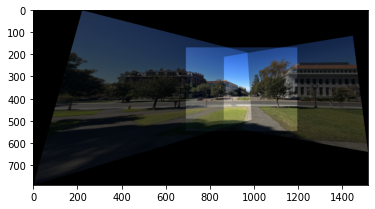

In [35]:
plt.imshow(blended)

In [ ]:
blended = (leftwarped[..., :3] * leftwarped[..., 3:] + rightwarped[..., :3] * rightwarped[..., 3:] + dst[..., :3] * dst[..., 3:]) # *full_mask
opacity = leftwarped[..., 3:] + rightwarped[..., 3:] + dst[..., 3:]
opacity[opacity == 0] = 1
blended = blended/opacity

In [ ]:
    
# bounds = [getWarpedImBounds[]]
# lh_min, lw_min, lh_max, lw_max = getWarpedImBounds(left, H_left)
# rh_min, rw_min, rh_max, rw_max = getWarpedImBounds(right, H_right)

# h_min = min(lh_min, rh_min, 0)
# w_min = min(lw_min, rw_min, 0)
# h_max = max(lh_max - lh_min, rh_max, dst.shape[0])
# w_max = max(lw_max - lw_min, rw_max, dst.shape[1])

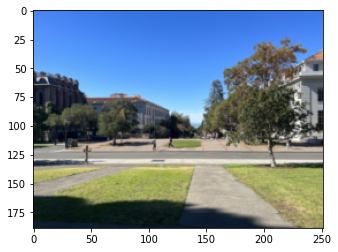

In [256]:
plt.imshow(ims[1])

In [257]:
patches = []
for c in corners:
    patch = bw_left[c[0] - 20: c[0] + 20, c[1] - 20: c[1] + 20]
    patch = ski.transform.rescale(patch, 1/5, channel_axis=2)
    patch = (patch - patch.mean(axis=1))/patch.std(axis=1)
    patches.append(patch.flatten())
patches = np.array(patches)

In [70]:
fdists = cdist(patches, patches)

NameError: name 'cdist' is not defined

In [298]:
asort = np.argsort(fdists, axis=1)

In [310]:
fdists_sorted = fdists[np.tile(np.arange(nip)[:, np.newaxis], nip), asort]

In [311]:
outlier_score = fdists_sorted[:, 0]/fdists_sorted[:, 1]

In [312]:
outlier_threshold = 0.4
matches = np.argwhere(outlier_score < outlier_threshold)

In [313]:
matches.shape

(16, 1)

In [ ]:
corrs = matches

In [314]:
matches

array([[  2],
       [ 17],
       [ 40],
       [ 52],
       [ 65],
       [123],
       [170],
       [189],
       [195],
       [218],
       [265],
       [314],
       [316],
       [323],
       [369],
       [399]], dtype=int64)

In [ ]:
left_pts = np.array(corrs["leftcenter"]["im1Points"])
centerleft_pts = np.array(corrs["leftcenter"]["im2Points"])

centerright_pts = np.array(corrs["centerright"]["im1Points"])
right_pts = np.array(corrs["centerright"]["im2Points"])

In [ ]:
scale = .5
left = ski.transform.rescale(left, scale, channel_axis=2)
center = ski.transform.rescale(center, scale, channel_axis=2)
right = ski.transform.rescale(right, scale, channel_axis=2)
left_pts = left_pts*scale
centerleft_pts = centerleft_pts*scale
centerright_pts = centerright_pts*scale
right_pts = right_pts*scale

In [ ]:
plt.imshow(left)

In [ ]:
topgrad = np.tile(np.linspace(0, 1, left.shape[0]//2)[:, np.newaxis], left.shape[1])
bottomgrad = np.tile(np.linspace(1, 0, left.shape[0]//2)[:, np.newaxis], left.shape[1])
leftgrad = np.tile(np.linspace(0, 1, left.shape[1]//2)[:, np.newaxis], left.shape[0])
rightgrad = np.tile(np.linspace(1, 0, left.shape[1]//2)[:, np.newaxis], left.shape[0])

vertgrad = np.concatenate([topgrad, bottomgrad])
horzgrad = np.concatenate([leftgrad, rightgrad]).T
grad = horzgrad*vertgrad

In [ ]:
left = np.concatenate([left, grad[..., np.newaxis]], axis=-1)
right = np.concatenate([right, grad[..., np.newaxis]], axis=-1)
center = np.concatenate([center, 2*grad[..., np.newaxis]], axis=-1)

In [ ]:
H_left = computeH(left_pts, centerleft_pts)
H_right = computeH(right_pts, centerright_pts)

In [ ]:
left.shape

In [ ]:
testwarp = warpImage(left, H_left, -200, -600, center.shape[0] + 200,  200 + center.shape[1])

In [ ]:
plt.imshow(testwarp)

In [ ]:
visualize_points(right_pts, right)

In [ ]:
visualize_points(centerright_pts, center)

In [ ]:
dst = center
lh_min, lw_min, lh_max, lw_max = getWarpedImBounds(left, H_left)
rh_min, rw_min, rh_max, rw_max = getWarpedImBounds(right, H_right)

h_min = min(lh_min, rh_min, 0)
w_min = min(lw_min, rw_min, 0)
h_max = max(lh_max - lh_min, rh_max, dst.shape[0])
w_max = max(lw_max - lw_min, rw_max, dst.shape[1])

In [ ]:
# Shape the destination image to be in the right location
dst = np.pad(dst, np.abs([[h_min, h_max - dst.shape[0]], [w_min, w_max - dst.shape[1]], [0, 0]]))

In [ ]:
leftwarped = warpImage(left, H_left, h_min, w_min, h_max, w_max)
rightwarped = warpImage(right, H_right, h_min, w_min, h_max, w_max)

In [ ]:
blended = (leftwarped[..., :3] * leftwarped[..., 3:] + rightwarped[..., :3] * rightwarped[..., 3:] + dst[..., :3] * dst[..., 3:]) # *full_mask
opacity = leftwarped[..., 3:] + rightwarped[..., 3:] + dst[..., 3:]
opacity[opacity == 0] = 1
blended = blended/opacity

In [ ]:
plt.imshow(blended)

In [ ]:
ski.io.imsave(f"{format_type}_panorama.jpg", (blended*255).astype(np.uint8))

In [ ]:
# Get a rectified version

In [ ]:
corrs.keys()

In [ ]:
rectify_im = skio.imread(f"imgs/hallway.jpg")
with open(f"correspondences/hallway_hallway.json") as fb:
    corrs["rectify"] = json.load(fb)
rectifyPoints = np.array(corrs["rectify"]["im1Points"])

In [ ]:
scale = 1
rectify_im = ski.transform.rescale(rectify_im, scale, channel_axis=2)
rectifyPoints = rectifyPoints*scale

In [ ]:
rectify_im.shape

In [ ]:
plt.imshow(rectify_im)

In [ ]:
visualize_points(rectifyPoints, rectify_im)

In [ ]:
rectify_im.shape

In [ ]:
H_rectify = computeH(rectifyPoints, np.array([[0, 0], [100, -100], [100, 100], [200, 0]]))

In [ ]:
rh_min, rw_min, rh_max, rw_max = getWarpedImBounds(rectify_im, H_rectify)

In [ ]:
rh_max

In [ ]:
rh_min

In [ ]:
rectify_warped = warpImage(rectify_im, H_rectify, rh_min - 1000, rw_min - 500, rh_max + 500, rw_max + 500)

In [ ]:
plt.imshow(rectify_warped)

In [ ]:
ski.io.imsave("rectified_hallway.jpg", (rectify_warped*255).astype(np.uint8))

In [ ]:
# Do the Dubrovnik ones

In [ ]:
left = skio.imread(f"imgs/dubrovnik_left.jpg")
right = skio.imread(f"imgs/dubrovnik_right.jpg")

In [ ]:
corrs = {} # Correspondences

In [ ]:
with open(f"correspondences/dubrovnik_left_dubrovnik_right.json") as fb:
    dubrovnik_pts = json.load(fb)

In [ ]:
left_pts = np.array(dubrovnik_pts["im1Points"])
right_pts = np.array(dubrovnik_pts["im2Points"])

In [ ]:
scale = .5
left = ski.transform.rescale(left, scale, channel_axis=2)
right = ski.transform.rescale(right, scale, channel_axis=2)
left_pts = left_pts*scale
right_pts = right_pts*scale

In [ ]:
plt.imshow(left)

In [ ]:
plt.imshow(right)

In [ ]:
topgrad = np.tile(np.linspace(0, 1, left.shape[0]//2)[:, np.newaxis], left.shape[1])
bottomgrad = np.tile(np.linspace(1, 0, left.shape[0]//2)[:, np.newaxis], left.shape[1])
leftgrad = np.tile(np.linspace(0, 1, left.shape[1]//2)[:, np.newaxis], left.shape[0])
rightgrad = np.tile(np.linspace(1, 0, left.shape[1]//2)[:, np.newaxis], left.shape[0])

vertgrad = np.concatenate([topgrad, bottomgrad])
horzgrad = np.concatenate([leftgrad, rightgrad]).T
grad = horzgrad*vertgrad

In [ ]:
left = np.concatenate([left, grad[..., np.newaxis]], axis=-1)
right = np.concatenate([right, grad[..., np.newaxis]], axis=-1)

In [ ]:
H_left = computeH(left_pts, right_pts)

In [ ]:
dst = right
h_min, w_min, h_max, w_max = getWarpedImBounds(left, H_left)

h_min = min(h_min, 0)
w_min = min(w_min, 0)
h_max = max(h_max, dst.shape[0])
w_max = max(w_max, dst.shape[1])

In [ ]:
h_min

In [ ]:
# Shape the destination image to be in the right location
dst = np.pad(dst, np.abs([[h_min, h_max - dst.shape[0]], [w_min, w_max - dst.shape[1]], [0, 0]]))

In [ ]:
leftwarped = warpImage(left, H_left, h_min, w_min, h_max, w_max)

In [ ]:
blended = (leftwarped[..., :3] * leftwarped[..., 3:] + dst[..., :3] * dst[..., 3:]) # *full_mask
opacity = leftwarped[..., 3:] + dst[..., 3:]
opacity[opacity == 0] = 1
blended = blended/opacity

In [ ]:
plt.imshow(blended)

In [ ]:
ski.io.imsave("dubrovnik_panorama.jpg", (blended*255).astype(np.uint8))